<a href="https://colab.research.google.com/github/jwvrolijk/masterclass2020/blob/master/masterclass2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup python environment using keras and tensorflow

In [0]:
# To determine which version you're using:
#!pip show tensorflow

# For the current version: 
#!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow==2.0.0-alpha0 

import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Model, Sequential
from keras.layers import Add, Input, Dense, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Activation
from keras.callbacks import TensorBoard
import math as m
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
#uncomment next line if you run on google collab#
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
!git clone https://github.com/jwvrolijk/masterclass2020.git

Using TensorFlow backend.


# Create function for ghost model

In [0]:
#Function to model ghost function
#input parameters
#nx    - number of spatial samples
#nfreq - number of frequency samples
#df    - frequency sampling
#depth - the depth of sources and receivers 
#c     - propagation velocity in water
#output parameter
#G     - ghost model in frequency domain according to matrix notation
def GhostMod(nx,dx,nfreq,df,depth,c):
    omega=2.0*m.pi*df*np.arange(0,nfreq)

    k_x=np.hstack((np.arange(0,(nx/2)+1),np.arange(-(nx/2)+1,0)))*2*m.pi/nx/dx
    [fk_k,fk_f]=np.complex64(np.meshgrid(k_x, omega))

    kz=np.sqrt(fk_f*fk_f/(c*c)-fk_k*fk_k)
    G=np.ones((fk_k.shape[0],fk_f.shape[1]))-0.99*np.exp(-1j*2*depth*np.conj(kz))

    return G

# Load binary data and apply Fourier transforms

In [0]:
#The number of receivers and sources
nrec=480
nsrc=480
#Spatial sampling
dx=12.5
#Time samples and sampling
nt=480
dt=0.004
#Frequency sampling
df=1/(nt*dt)
#Maximum frequency and number of frequencies to view in plots
fmax=60
nfreq=int(fmax/df)+1
#Read in seismic data and reshape to matrix notation (binary format)
p=np.reshape(np.fromfile('masterclass2020/shots.P0.part1.bin', dtype=np.float32, count=-1, sep=''),[100,nrec,nt]).T
p=np.append(p,np.reshape(np.fromfile('masterclass2020/shots.P0.part2.bin', dtype=np.float32, count=-1, sep=''),[100,nrec,nt]).T,axis=2)
p=np.append(p,np.reshape(np.fromfile('masterclass2020/shots.P0.part3.bin', dtype=np.float32, count=-1, sep=''),[100,nrec,nt]).T,axis=2)
p=np.append(p,np.reshape(np.fromfile('masterclass2020/shots.P0.part4.bin', dtype=np.float32, count=-1, sep=''),[100,nrec,nt]).T,axis=2)
p=np.append(p,np.reshape(np.fromfile('masterclass2020/shots.P0.part5.bin', dtype=np.float32, count=-1, sep=''),[80,nrec,nt]).T,axis=2)#Apply Fourier transform over time axis
P=np.fft.rfft(p,axis=0)
#Apply Fourier transform over spatial axes
Pk=np.fft.fft(np.fft.fft(P,axis=1),axis=2)

# Plot data

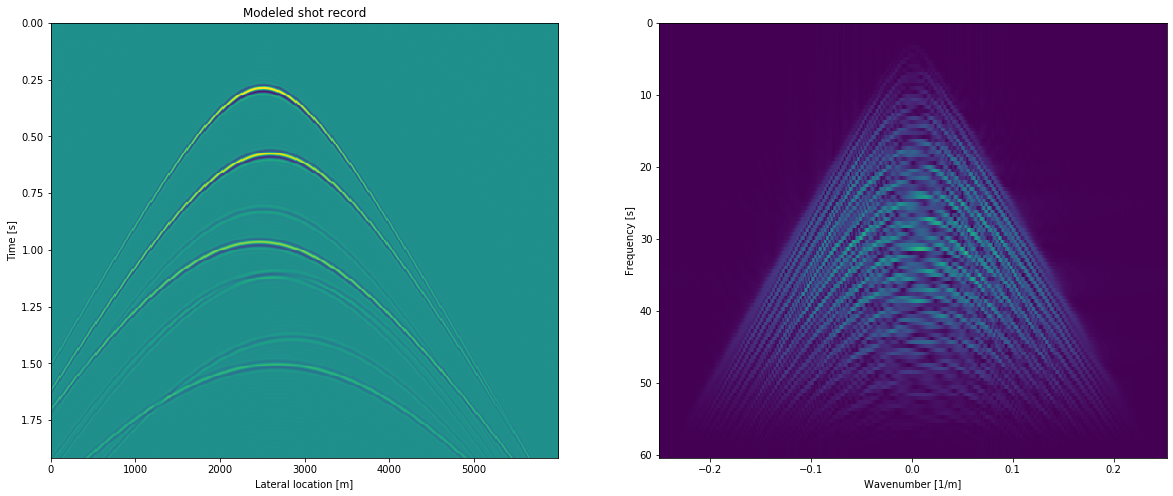

In [0]:
#Check shot number #maximum 
shot=200

#sampling in wavenumber domain
dkx=2*m.pi/nrec/dx

#Plot shot record in time space and wavenumber frequency domain
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(p[:,:,shot],extent=[0,dx*(nrec-1),dt*(nt-1),0],vmin=-3e-3,vmax=3e-3,aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Modeled shot record')

ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(P[:,:,shot],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],vmin=0,vmax=1.5,aspect='auto')
ax2.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax2.set_xlabel('Wavenumber [1/m]')
ax2.set_ylabel('Frequency [s]')
plt.show()

# Add ghost to model

1.5188299795562332


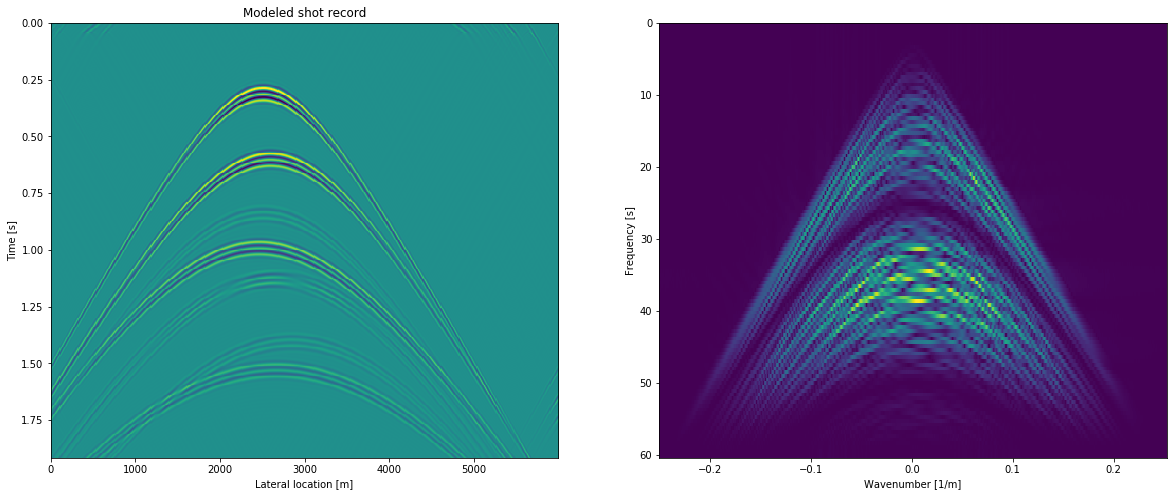

In [0]:
#Set depth of receivers
depth=30
#Set propagation velocity
c=1500
    
#Create ghost model and apply
G=GhostMod(nrec,dx,(nt/2)+1,df,depth,c)
GP=np.fft.ifft(np.einsum('ij,ijk->ijk',G,np.fft.fft(P,axis=1)),axis=1)
        
#Plot shot record including ghost in time space and wavenumber frequency domain
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.fft.irfft(GP[:,:,shot],axis=0),extent=[0,dx*(nrec-1),dt*(nt-1),0],vmin=-3e-3,vmax=3e-3,aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Modeled shot record')

ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(GP[:,:,shot],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],vmin=0,vmax=1.5,aspect='auto')
ax2.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax2.set_xlabel('Wavenumber [1/m]')
ax2.set_ylabel('Frequency [s]')
plt.show()

# Subsample data

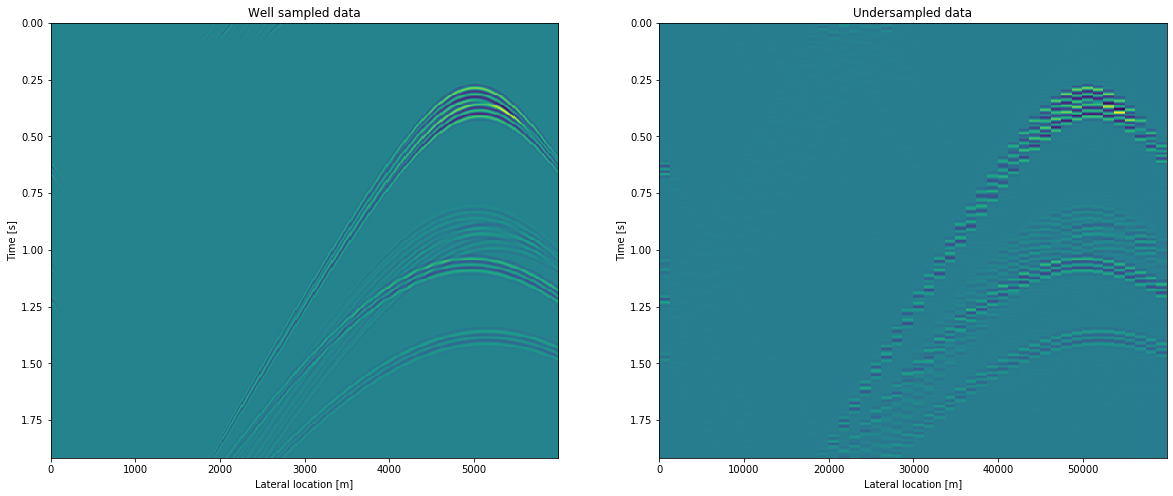

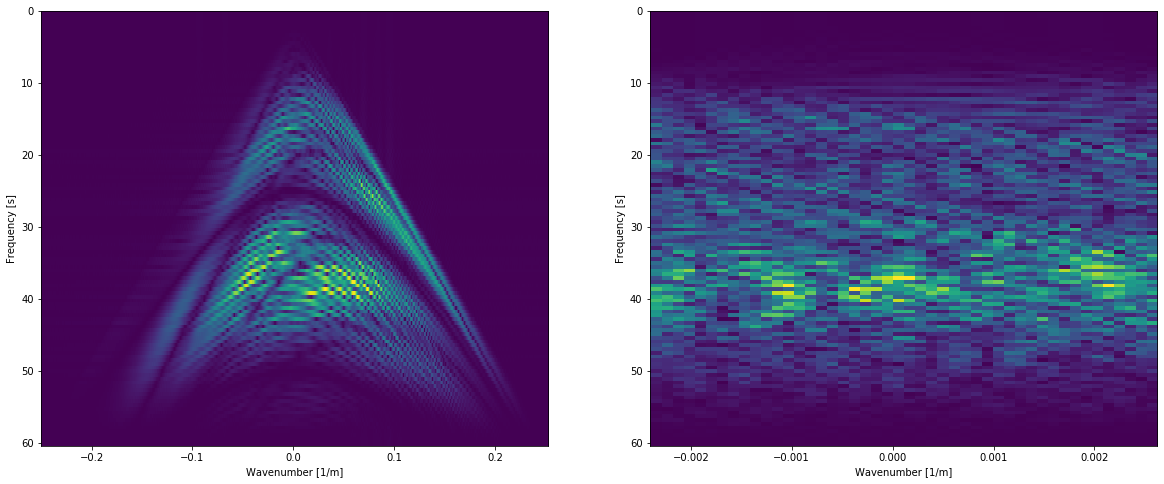

In [0]:
#Subsampling receiver factor (use factor=10 to limit training time during masterclass)
factor=10
shot=400

#Spatial sampling after subsampling
dxsub=dx*factor
nsub=int(nrec/factor)
dksub=2*m.pi/nsrc/dxsub

#Subsample the shot records including the ghost
GPsub=GP[:,0::factor,:]

#Plot shot record vs subsampled shot record in time space and wavenumber frequency domain
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.fft.irfft(GP[:,:,shot],axis=0),extent=[0,dx*(nrec-1),dt*(nt-1),0],aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Well sampled data')

ax2.imshow(np.fft.irfft(GPsub[:,:,shot],axis=0),extent=[0,dxsub*(nsrc-1),dt*(nt-1),0],aspect='auto')
ax2.axis([0,(nsrc-1)*dxsub,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Undersampled data')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.absolute(np.fft.fftshift(np.fft.fft(GP[:,:,shot],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],vmin=0,vmax=1.5,aspect='auto')
ax1.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax1.set_xlabel('Wavenumber [1/m]')
ax1.set_ylabel('Frequency [s]')

ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(GPsub[:,:,shot],axis=1),axes=1)),extent=[-((nsub/2)+1)*dksub,((nsub/2)+1)*dksub,df*(nt/2),0],vmin=0,vmax=1.5*2/factor,aspect='auto')
ax2.axis([(-(nsub/2)+1)*dksub,((nsub/2)+1)*dksub,nfreq*df,0])
ax2.set_xlabel('Wavenumber [1/m]')
ax2.set_ylabel('Frequency [s]')
plt.show()

# Deghost data


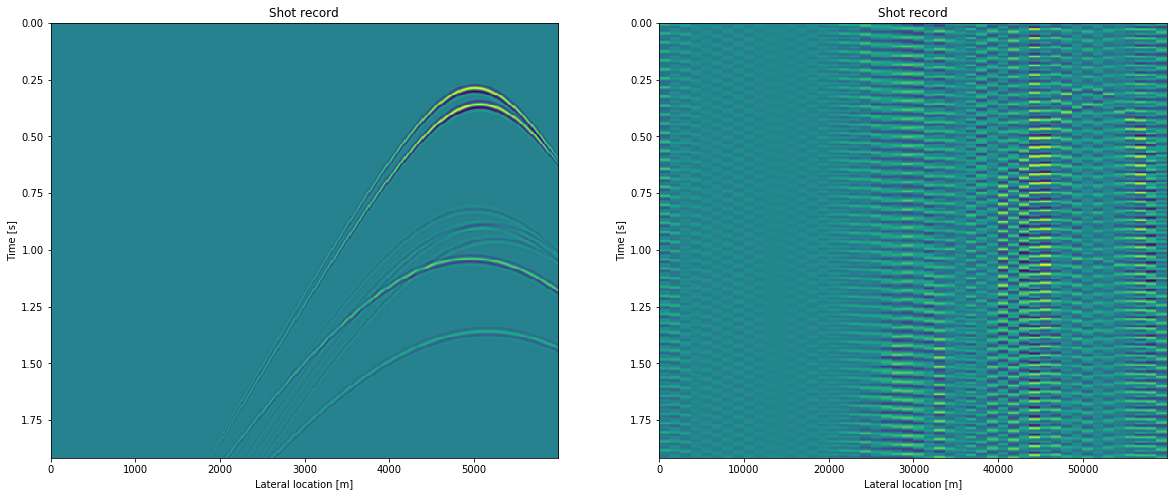

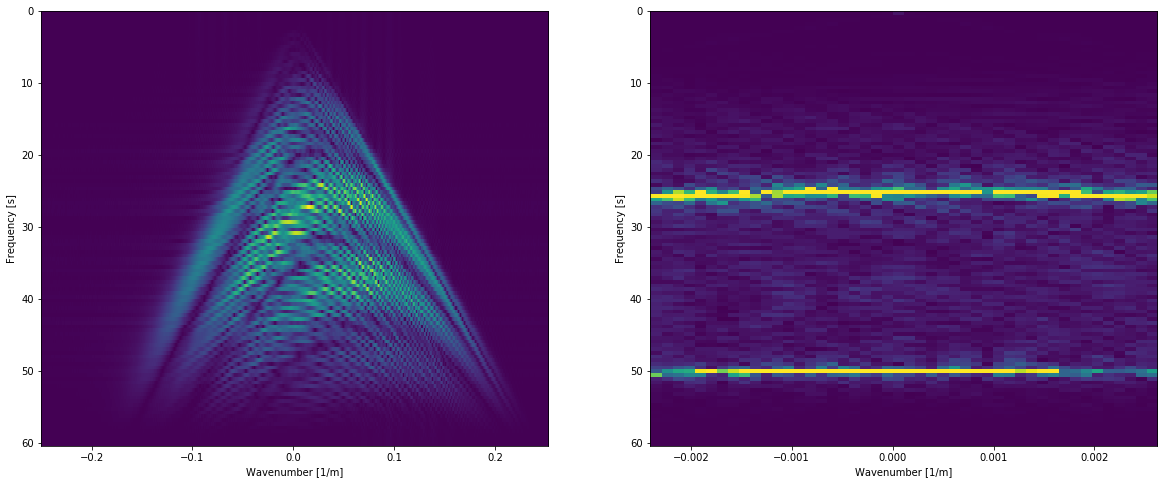

In [0]:
#Apply deghosting to well-sampled data
Ymeas=np.fft.ifft(np.einsum('ij,ijk->ijk',(1/G),np.fft.fft(GP,axis=1)),axis=1)

#Apply deghosting to subsampled data
Gsub=GhostMod(nsub,dxsub,nt/2+1,df,depth,c)
Ysub=np.fft.ifft(np.einsum('ij,ijk->ijk',(1/Gsub),np.fft.fft(GPsub,axis=1)),axis=1)

#Plot deghosting results
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.fft.irfft(Ymeas[:,:,shot],axis=0),extent=[0,dx*(nrec-1),dt*(nt-1),0],aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Shot record')

ax2.imshow(np.fft.irfft(Ysub[:,:,shot],axis=0),extent=[0,dxsub*(nsrc-1),dt*(nt-1),0],aspect='auto')
ax2.axis([0,(nsrc-1)*dxsub,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Shot record')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(np.absolute(np.fft.fftshift(np.fft.fft(Ymeas[:,:,shot],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],vmin=0,vmax=1,aspect='auto')
ax1.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax1.set_xlabel('Wavenumber [1/m]')
ax1.set_ylabel('Frequency [s]')

ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(Ysub[:,:,shot],axis=1),axes=1)),extent=[-((nsub/2)+1)*dksub,((nsub/2)+1)*dksub,df*(nt/2),0],vmin=0,vmax=1,aspect='auto')
ax2.axis([(-(nsub/2)+1)*dksub,((nsub/2)+1)*dksub,nfreq*df,0])
ax2.set_xlabel('Wavenumber [1/m]')
ax2.set_ylabel('Frequency [s]')
plt.show()

# Split subsampled data in training data (even shots) and validation data (odd shots)


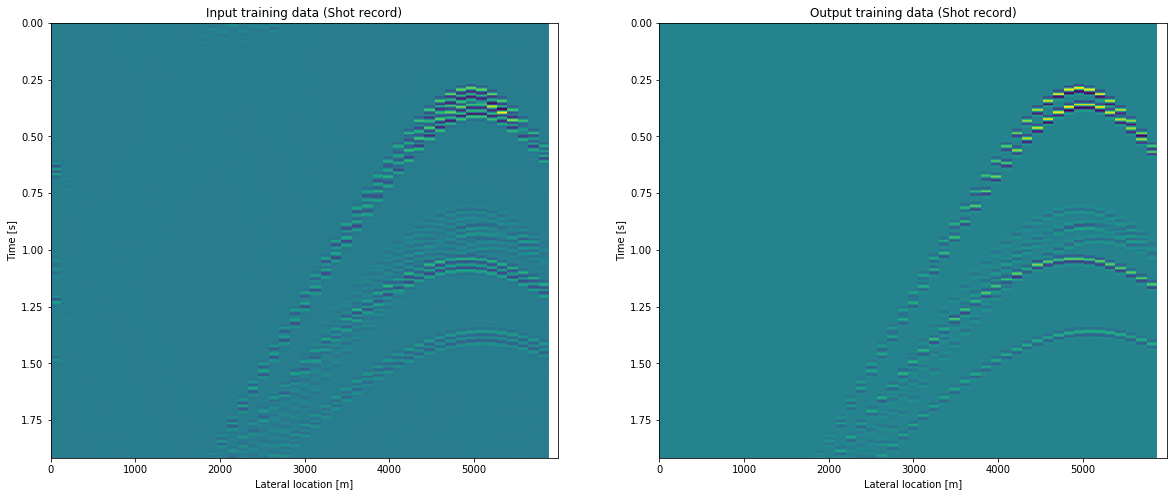

In [0]:
#Apply inverse fourier transform to data including and excluding ghost
ymeas=np.fft.irfft(Ymeas,axis=0)
xmeas=np.fft.irfft(GP,axis=0)
shot=200
#Subsampled data before and after deghosting
y= np.empty((nt,nsub,0), int)
x= np.empty((nt,nsub,0), int)
y=ymeas[:,0::factor,:]
x=xmeas[:,0::factor,:]

#even numbers are training data #odd records are validation data
ytrain=y[:,:,0::2]
xtrain=x[:,:,0::2]
yval=y[:,:,1::2]
xval=x[:,:,1::2]

#Plot training data
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(xtrain[:,:,shot],extent=[0,dxsub*(nsub-1),dt*(nt-1),0],aspect='auto')
ax1.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Input training data (Shot record)')

ax2.imshow(ytrain[:,:,shot],extent=[0,dxsub*(nsub-1),dt*(nt-1),0],aspect='auto')
ax2.axis([0,(nrec-1)*dx,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Output training data (Shot record)')
plt.show()

#fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
#ax1.imshow(np.absolute(np.fft.fftshift(np.fft.fft(Xtrain[:,:,1],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],aspect='auto')
#ax1.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
#ax1.set_xlabel('Wavenumber [1/m]')
#ax1.set_ylabel('Frequency [s]')

#ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(Ytrain[:,:,1],axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],aspect='auto')
#ax2.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
#ax2.set_xlabel('Wavenumber [1/m]')
#ax2.set_ylabel('Frequency [s]')
#plt.show()

# Prepare data for learning


In [0]:
#normalize training data before feeding in to neural network
mean = np.mean(xtrain,axis=(1,2))
mean = mean[:, np.newaxis, np.newaxis]
std = np.std(xtrain,axis=(1,2))
std = std[:, np.newaxis, np.newaxis]

xtrain-=mean
xtrain/=std
ytrain-=mean
ytrain/=std

#re-arrange training data to tensorflow neural network format (training sets/shots, time samples, spatial samples, 1)
xtrain = np.moveaxis(xtrain, -1, 0)
ytrain = np.moveaxis(ytrain, -1, 0)
xtrain = xtrain[:, :, :, np.newaxis]
ytrain = ytrain[:, :, :, np.newaxis]

#normalize validation data before feeding in to neural network
mean = np.mean(xval,axis=(1,2))
mean = mean[:, np.newaxis, np.newaxis]
std = np.std(xval,axis=(1,2))
std = std[:, np.newaxis, np.newaxis]

xval-=mean
xval/=std
yval-=mean
yval/=std

#normalize validation data before feeding in to neural network
xval = np.moveaxis(xval, -1, 0)
yval = np.moveaxis(yval, -1, 0)
xval = xval[:, :, :, np.newaxis]
yval = yval[:, :, :, np.newaxis]


# Create simple convolutional encoder-decoder network


In [0]:
# Build 4 layer encoding-decoding network
# (1 encoding layers - 1 connecting layer - 1 decoding layers - 1 output layer)
def Encoding_Decoding1(nt,nx,nfilter):
    inputs = Input((nt, nx, 1))

    #create encoding layer
    c1 = Conv2D(nfilter, (3, 3), padding='same') (inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    
    #connecting layer
    c2 = Conv2D(nfilter*2, (3, 3), padding='same') (p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    #create decoding layer
    u3 = Conv2DTranspose(nfilter, (2, 2), strides=(2, 2), padding='same') (c2)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Add()([u3, c1])

    #create output layer
    outputs = Conv2D(1, (1, 1)) (u3)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Summary of simple convolutional encoder-decoder network


In [0]:
model1=Encoding_Decoding1(nt,nsub,8)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 48, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 48, 8)   80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 480, 48, 8)   32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 480, 48, 8)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

# Train simple convolutional encoder-decoder network


In [0]:
model1.compile(optimizer='adam', loss='mean_squared_error')
model1.fit(xtrain, ytrain,
                epochs=5,
                batch_size=1,
                shuffle=True,validation_data=(xval,yval))

Train on 240 samples, validate on 240 samples
Epoch 1/5
240/240 [==============================] - 33s 137ms/step - loss: 0.4341 - val_loss: 0.2793
Epoch 2/5
240/240 [==============================] - 27s 111ms/step - loss: 0.2423 - val_loss: 0.2293
Epoch 3/5
240/240 [==============================] - 30s 125ms/step - loss: 0.2190 - val_loss: 0.2109
Epoch 4/5
240/240 [==============================] - 26s 109ms/step - loss: 0.2030 - val_loss: 0.1999
Epoch 5/5
240/240 [==============================] - 25s 105ms/step - loss: 0.1880 - val_loss: 0.1801


# Apply simple convolutional encoder-decoder network on validation data


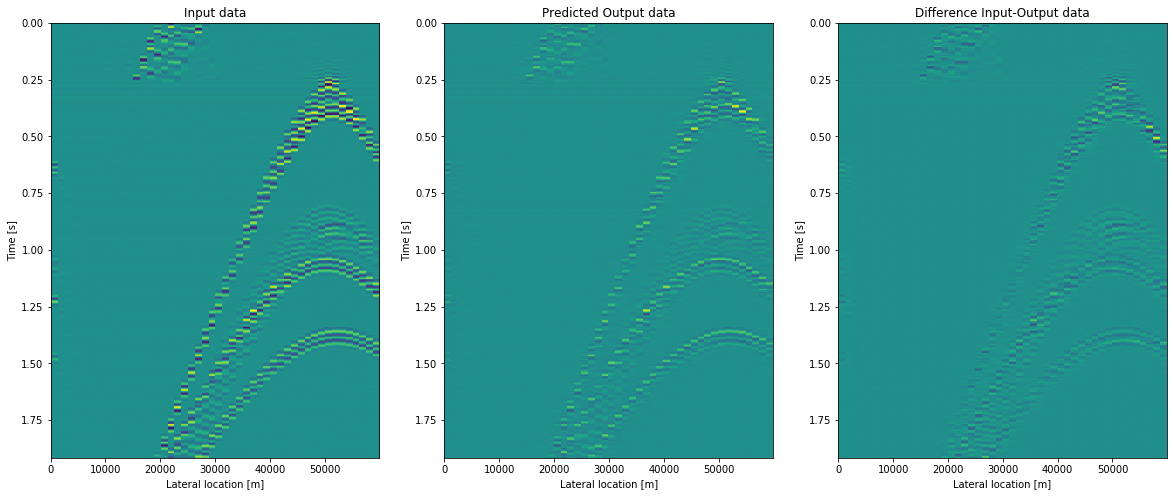

In [0]:
ypred = model1.predict(xval)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
ax1.imshow(xval[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax1.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Input data')
ax2.imshow(ypred[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax2.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Predicted Output data')
ax3.imshow(yval[shot,:,:,0]-ypred[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax3.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax3.set_xlabel('Lateral location [m]')
ax3.set_ylabel('Time [s]')
ax3.set_title('Difference Input-Output data')
plt.show()

# Create deep convolutional encoder-decoder network


In [0]:
# Build 8 layer encoding-decoding network
# (3 encoding layers - 1 connecting layer - 3 decoding layers - 1 output layer)
def Encoding_Decoding3(nt,nx,nfilter):

    # Create a new model instance
    #model = create_model()
    inputs = Input((nt, nx, 1))

    c1 = Conv2D(nfilter, (3, 3), padding='same') (inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(nfilter*2, (3, 3), padding='same') (p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(nfilter*3, (3, 3), padding='same') (p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(nfilter*4, (3, 3), padding='same') (p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u5 = Conv2DTranspose(nfilter*3, (2, 2), strides=(2, 2), padding='same') (c4)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)
    u5 = Add()([u5, c3])

    u6 = Conv2DTranspose(nfilter*2, (2, 2), strides=(2, 2), padding='same') (u5)
    u6 = BatchNormalization()(u6)
    u6 = Activation('relu')(u6)
    u6 = Add()([u6, c2])

    u7 = Conv2DTranspose(nfilter, (2, 2), strides=(2, 2), padding='same') (u6)
    u7 = BatchNormalization()(u7)
    u7 = Activation('relu')(u7)
    u7 = Add()([u7, c1])

    outputs = Conv2D(1, (1, 1)) (u7)
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Summary of deep convolutional encoder-decoder network


In [0]:
model_deep = Encoding_Decoding3(nt,nsub,32)
model_deep.summary()
model_deep.compile(optimizer='adam', loss='mean_squared_error')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 480, 48, 1)   0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 480, 48, 32)  320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 480, 48, 32)  128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 480, 48, 32)  0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

# Train deep convolutional encoder-decoder network


In [0]:
model_deep.fit(xtrain, ytrain,
                epochs=100,
                batch_size=1,
                shuffle=True,validation_data=(xval,yval))

Train on 240 samples, validate on 240 samples
Epoch 1/100
240/240 [==============================] - 114s 477ms/step - loss: 0.0436 - val_loss: 0.0477
Epoch 2/100
240/240 [==============================] - 114s 474ms/step - loss: 0.0393 - val_loss: 0.0408
Epoch 3/100
240/240 [==============================] - 114s 476ms/step - loss: 0.0361 - val_loss: 0.0393
Epoch 4/100
240/240 [==============================] - 113s 472ms/step - loss: 0.0336 - val_loss: 0.0371
Epoch 5/100
240/240 [==============================] - 114s 475ms/step - loss: 0.0316 - val_loss: 0.0347
Epoch 6/100
240/240 [==============================] - 114s 473ms/step - loss: 0.0299 - val_loss: 0.0328
Epoch 7/100
240/240 [==============================] - 115s 477ms/step - loss: 0.0282 - val_loss: 0.0320
Epoch 8/100
240/240 [==============================] - 114s 477ms/step - loss: 0.0266 - val_loss: 0.0315
Epoch 9/100
240/240 [==============================] - 113s 472ms/step - loss: 0.0256 - val_loss: 0.0315
Epoch 10/

# Apply deep convolutional encoder-decoder network on validation data


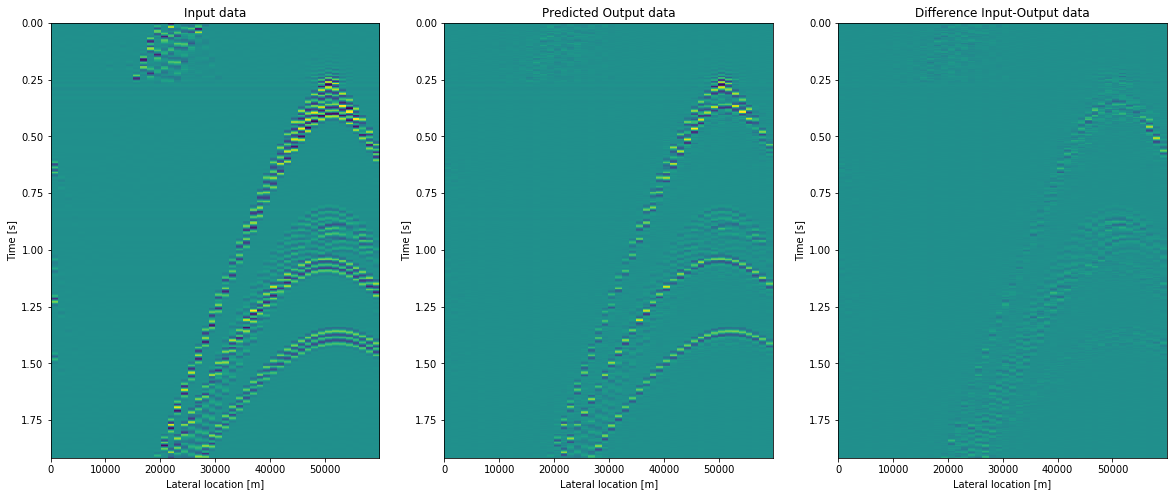

In [0]:
ypred = model_deep.predict(xval)

# Results of deep convolutional encoder-decoder network on validation data


Text(0, 0.5, 'Frequency [s]')

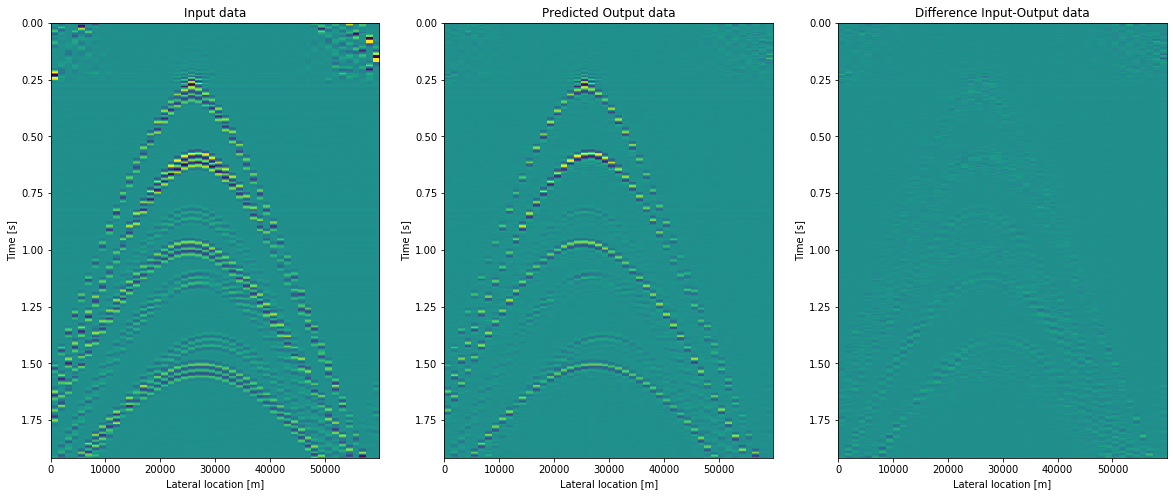

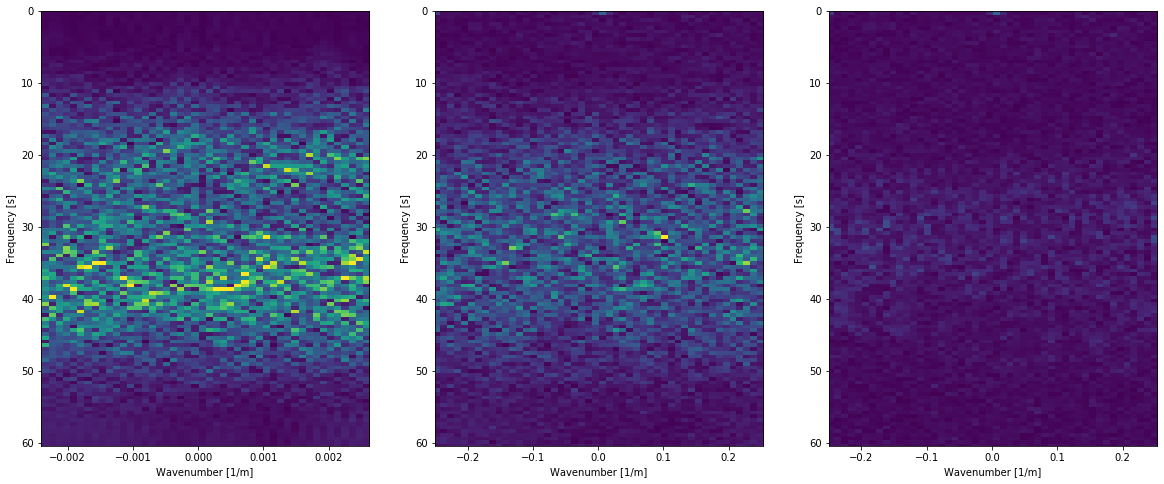

In [0]:
shot=100

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
ax1.imshow(xval[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax1.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax1.set_xlabel('Lateral location [m]')
ax1.set_ylabel('Time [s]')
ax1.set_title('Input data')
ax2.imshow(ypred[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax2.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax2.set_xlabel('Lateral location [m]')
ax2.set_ylabel('Time [s]')
ax2.set_title('Predicted Output data')
ax3.imshow(yval[shot,:,:,0]-ypred[shot,:,:,0],extent=[0,dxsub*(nrec-1),dt*(nt-1),0],aspect='auto', vmin=-7, vmax=7)
ax3.axis([0,(nrec-1)*dxsub,(nt-1)*dt,0])
ax3.set_xlabel('Lateral location [m]')
ax3.set_ylabel('Time [s]')
ax3.set_title('Difference Input-Output data')

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,8))
ax1.imshow(np.absolute(np.fft.fftshift(np.fft.fft(np.fft.rfft(xval[shot,:,:,0],axis=0),axis=1),axes=1)),extent=[-((nsub/2)+1)*dksub,((nsub/2)+1)*dksub,df*(nt/2),0],vmin=0,vmax=4000*2/factor,aspect='auto')
ax1.axis([(-(nsub/2)+1)*dksub,((nsub/2)+1)*dksub,nfreq*df,0])
ax1.set_xlabel('Wavenumber [1/m]')
ax1.set_ylabel('Frequency [s]')
ax2.imshow(np.absolute(np.fft.fftshift(np.fft.fft(np.fft.rfft(ypred[shot,:,:,0],axis=0),axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],vmin=0,vmax=4000*2/factor,aspect='auto')
ax2.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax2.set_xlabel('Wavenumber [1/m]')
ax2.set_ylabel('Frequency [s]')
ax3.imshow(np.absolute(np.fft.fftshift(np.fft.fft(np.fft.rfft(yval[shot,:,:,0]-ypred[shot,:,:,0],axis=0),axis=1),axes=1)),extent=[-((nrec/2)+1)*dkx,((nrec/2)+1)*dkx,df*(nt/2),0],vmin=0,vmax=4000*2/factor,aspect='auto')
ax3.axis([(-(nrec/2)+1)*dkx,((nrec/2)+1)*dkx,nfreq*df,0])
ax3.set_xlabel('Wavenumber [1/m]')
ax3.set_ylabel('Frequency [s]')

# Load pre-trained model to apply deghosting
